# DisQover Demonstrator Notebook

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets
from DisQover import QRW_simulation, CRW_simulation, QRW_qiskit_simulation, harmonic_QRW_simulation, QRW_visualization, QRW_optimization

#%matplotlib inline
sns.set_style("darkgrid")

## <span style='font-size:xx-large'>Table of Contents</span>

<span style='font-size:x-large'>\(1\) Classical Random Walks</span>

<span style='font-size:x-large'>\(2\) Quantum Random Walks</span>

<span style='font-size:large'>  &nbsp; &nbsp; 2.1 Quantum Circuit implementations of a QRW in Qiskit</span>

<span style='font-size:large'>  &nbsp; &nbsp; 2.2 Classical implementation of a QRW</span>

<span style='font-size:large'>  &nbsp; &nbsp; 2.3 Faster QRW Simulation & Promotion to Higher Dimensions

<span style='font-size:x-large'>\(3\) Variations of QRW</span>

<span style='font-size:large'> &nbsp; &nbsp; 3.1 Two\-dimensional QRW</span>

<span style='font-size:large'> &nbsp; &nbsp; 3.2 Harmonic QRW</span>

<span style='font-size:large'> &nbsp; &nbsp; 3.3 QRW with Qutrit</span>

<span style='font-size:large'>    3.4 QRW with Memory</span>

<span style='font-size:x-large'>\(4\)  Fitting QRWs


## (1) Classical Random Walks (CRW)



#### A **classical random walk \(CRW\)** is a mathematical process that models the movement of a walker where the direction of each step is determined by a random choice \(e.g. tossing a coin\). This process is commonly used to describe a range of phenomena across disciplines, like particle diffusion in physics or stock market fluctuations in economics.

#### A simple way to picture a classical random walk is as follows: the walker is placed at the initial site. Then, the first time step is taken: a coin is tossed. If the coin comes up heads, the walker takes one step to the left. If it comes up tails, he takes one step to the right. Then the second time step is taken: the coin is tossed again, and again, the walker moves left \(coin is heads up\) or right \(coin is tails up\). This process is repeated until the desired number of steps has been taken. If repeated many times, the histogram of final positions of the walker is \(approximately\) given by a normal distribution.

#### Using the CRW_simulation class, we can simulate a CRW process given the probability of each side of the coin, a probability distribution for the initial position of the walker, and the number of steps the walker takes. The output is the resulting probability distribution as a numpy array.

#### The cell below simulates this process, with a definite starting position at 0 \(rather than, for example, starting at \-2 with 50% probability and at \+5 with 50% probability, which is possible just as well\). The variable "coin\_probs" contains the probabilities for heads and tails. It is easy to verify with the code below that the mean of the resulting distribution for a fair coin is simply the starting position of the walker, while for a biased coin, it is the number of steps multiplied by the difference in the coin probabilities.



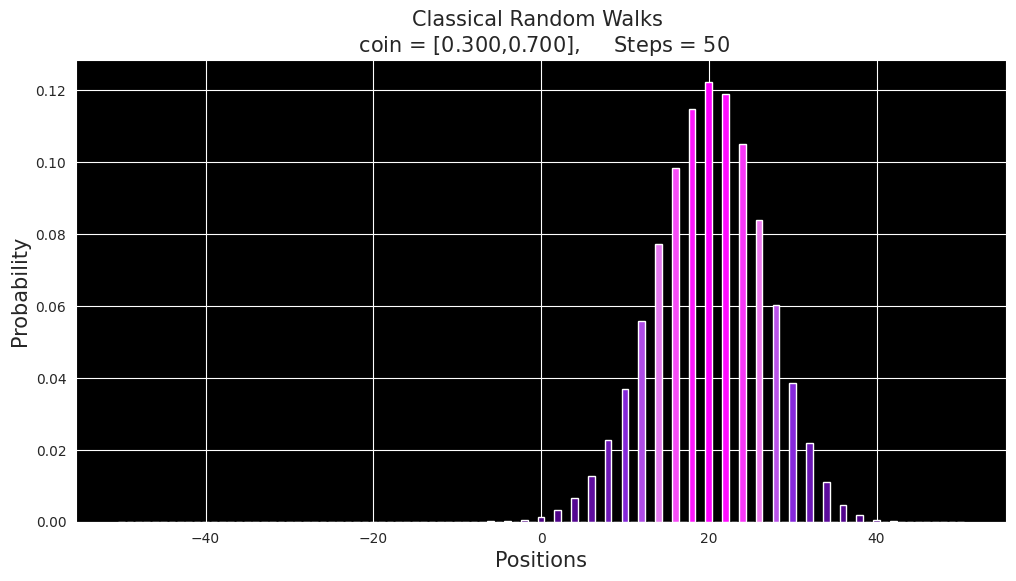

In [ ]:
coin_probs = [0.3,0.7]  # the probabilitiy of each side of the coin
crw_sim = CRW_simulation(coin_probs)

init_prob = np.array([1])  # the initial probability distribution of the walker
steps = 50 # number of steps the walker takes

crw_prob = crw_sim.simulate(init_prob,steps,plot=True)  # plot the histogram by specifying plot=True

## \(2\) Quantum Random Walks \(QRW\)



## <span style='font-size:large'>A </span><span style='font-size:large'>**quantum random walk \(QRW\)**</span><span style='font-size:large'> can be thought of as a random walk with a "quantum coin": instead of a classical coin which has two states, head and tails, which appear with probability </span><span style='font-size:large'>_**p**_</span><span style='font-size:large'> and </span><span style='font-size:large'>_**1\-p**_</span><span style='font-size:large'>, a quantum coin is a quantum bit, which is characterized by the probability amplitudes for heads and tails. The probability amplitudes are complex numbers, the squares of which sum up to one. Moreover, the position of the walker is recorded in a quantum register which is entangled with the quantum coin, such that all possible histories of the quantum coin tosses are contained in it in superposition, with the matching probability amplitude. If one measures the quantum register after </span><span style='font-size:large'>_**N**_</span><span style='font-size:large'> steps, the superposition collapses to a definite value \-\- one of the possible histories is picked. This last point is important, and a general feature of all quantum computation processes: all possible "results" exist in superposition, but to produce an output, a measurement is necessary, and the measurement collapses the superposition to a single result.</span>

<span style='font-size:large'>A key feature of this process is, that it is in general not diffusive, like the random walk, but wave-like. This disparity is evident in the behavior of the standard deviation </span><span style='font-size:large'>**σ**</span><span style='font-size:large'> of the probability distribution of the final position of the walker: \(see the animation below\)</span>

- <span style='font-size:large'>for classical random walks. the standard deviation grows as </span>$\sigma \sim \sqrt{N}$
- <span style='font-size:large'>for quantum random walks, the standard deviation grows as </span>$\sigma \sim N$

<span style='font-size:large'>This distinctive feature can be leveraged to develop efficient algorithms. For instance, QRWs are useful for:</span>

- <span style='font-size:large'>implementing quantum search → a quantum search algorithm can be implemented by QRW on complete graph \(see </span><span style='font-size:large'>_A. M. Childs, et al. Exponential Algorithmic Speedup by a Quantum Walk_</span><span style='font-size:large'>\),</span>
- <span style='font-size:large'>modelling of mobile agents in quantum networks → routing of quantum information based on a quantum state can be interpreted by QRW,</span>
- <span style='font-size:large'>analyzing the influence of the graph structure on the resulting quantum evolution → QRW can be easily applied to parametrize quantum processes using information about the underlying graph.</span>



<img src="./new_QRW_vs_CRW_std.gif" alt="Qiskit vs Classical Random Walks std" width="70%"/>



<span style='font-size:large'>The rule of to generate a QRW is similar to that for the CRW: for each step the walker takes,  "toss" the coin and the resulting coin state determines if the walker should move left or right. So the algorithm for a QRW schematically is given by:</span>

<span style='font-size:large'>Let the unitary coin flip operator </span>$U$ <span style='font-size:large'>\(there is a continuum of possible choices, and hence different QRW, for U\) act on the coin \(coin state\)</span>

<span style='font-size:large'>Let a shift operator </span>$S$ <span style='font-size:large'>act on the quantum register which records the position of the walker. A coin state of </span>$\ket{0}$<span style='font-size:large'> causes a shift to the left and a coin state of </span>$\ket{1}$<span style='font-size:large'> causes a step to the right.</span>


##### In more detail, the most general QRW is determined by:

##### 1. the \(initial\) coin state $\ket{C} = a\ket{0}+\sqrt{1-a^{2}}e^{i\phi}\ket{1}$

##### 2. the coin flip operator $U(\theta,\lambda)$

</br>

$$\begin{equation} U = \begin{pmatrix} \cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ \sin(\frac{\theta}{2}) & e^{i\lambda}\cos(\frac{\theta}{2}) \end{pmatrix} \end{equation}$$

</br>

##### The probability distribution of an 1D QRW can be simulated given these parameters and the initial probability amplitudes of the position state.



## 2.1 Simulating QRW with Qiskit



#### It is possible to simulate a QRW with a quantum circuit using a quantum simulator or quantum computer. To demonstrate how this can be done, we use the Qiskit Aer Simulator to sample the position states of an exemplary QRW process. Naturally, the probability distribution is subject to sampling errors, as the number of measurements is finite.

</br>

#### The quantum circuit will contain the two parts described above: a quantum coin, which is implemented with one qubit, and a position register \-\- we will use 4 qubits in our example \-\- which contains the position x of the quantum walk in binary code \(x=0,1,...,15\). So the positions have integer labels, where, for example, $\ket{1000}$ would code the position x=8, and $\ket{0011}$ the position x=3.

</br>

#### We will choose the initial condition of the position register to be x=8 since it is \(almost\) the midpoint of all the positions. This is easily achieved by applying an X\-gate to the most significant bit \(position3\).

</br>

#### In the circuit diagram shown, the coin is first initialized to the state $\ket{0}$. Then, a coin flip operator \(with $\theta=\frac{\pi}{3}$ and $\lambda=\frac{\pi}{4}$\) acts on the coin state, followed by a conditional shift operator acting on the position state. The shift operator can be decomposed into two parts: addition if the coin state is $\ket{0}$ and subtraction if the coin state is $\ket{1}$. The addition is executed with a sequence of \(multiply\) controlled NOT\-gates, targeting from the most significant to the least significant bit, while the subtraction is simply the inverse of the addition. The application of the coin flip and shift operators  is repeated for every step the walker takes.



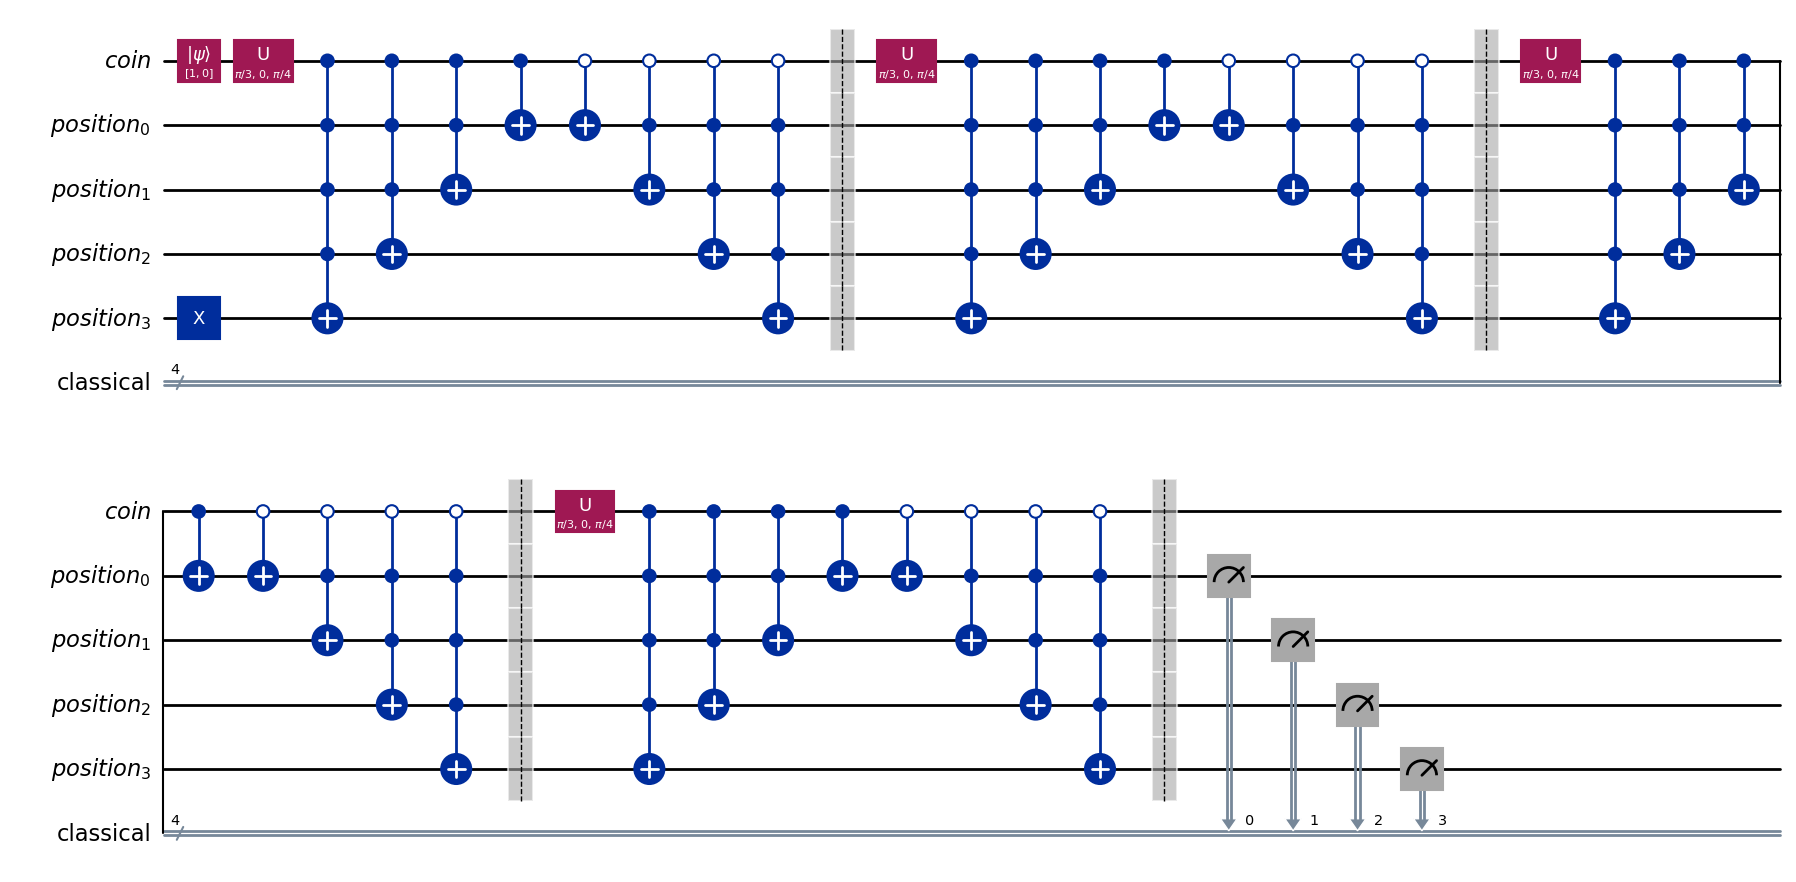

In [3]:
qiskit_sim = QRW_qiskit_simulation()
steps = 4
theta = np.pi/3
lamb = np.pi/4
coin_state = np.array([1,0])
circ = qiskit_sim.circuit(steps,theta,lamb,coin_state)  # the circuit can be plotted with the .circuit() method

#### The probability distribution of the position states of the QRW process can be sampled using the .simulate\(\) method



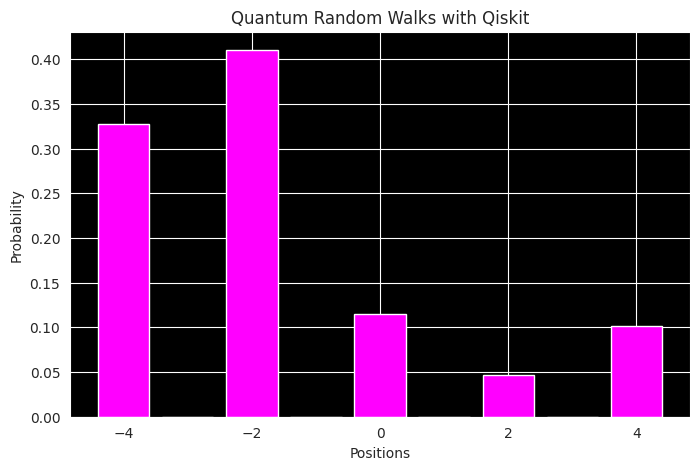

In [3]:
qiskit_dist = qiskit_sim.simulate(steps,theta,lamb,coin_state)
plt.figure(figsize=(8,5))
plt.gca().set_facecolor('black')
plt.bar(range(-steps,steps+1),qiskit_dist,color="magenta")
plt.title("Quantum Random Walks with Qiskit")
plt.xlabel("Positions")
plt.ylabel("Probability")
plt.show()

#### Most QRW distributions exhibit a pattern that skews to one side, similar to the randomly generated instance above. However, there are some special conditions under which the QRWs lead to symmetric distributions. For example, if we consider a balanced coin $\frac{1}{\sqrt{2}}(\ket{0}+i\ket{1})$ with the Hadamard gate as the coin flip operator, the resulting distribution will be symmetric about the initial position.

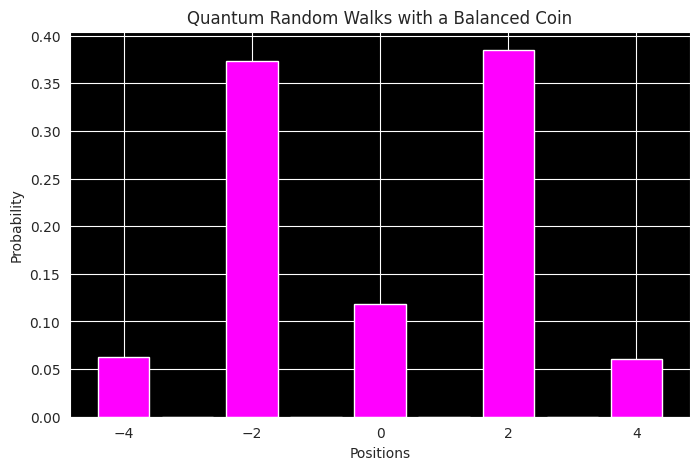

In [4]:
balanced_coin= np.array([1,1j])/2**0.5
qiskit_dist = qiskit_sim.simulate(steps,np.pi/2,np.pi,balanced_coin)  # Hadamard gate has the associated parameters: θ=π/2 and λ=π
plt.figure(figsize=(8,5))
plt.gca().set_facecolor('black')
plt.bar(range(-steps,steps+1),qiskit_dist,color="magenta")
plt.title("Quantum Random Walks with a Balanced Coin")
plt.xlabel("Positions")
plt.ylabel("Probability")
plt.show()

## 2.2 Simulating QRW Deterministically



#### QRWs can also be simulated efficiently and deterministically using classical methods, without the need for quantum simulators or hardware. This classical algorithm not only accomplishes the task in a more resource\-efficient manner, but also offers a number of additional advantages. The derivation of the algorithm is provided below:



#### The initial amplitude distribution can be considered as a vector or a discrete function with complex numbers as components $\vec{A} = A(x) = \sum_{x}A_{x}\ket{x}$ 

#### Assume the initial coin state $\ket{C} = a\ket{0}+b\ket{1} = a\ket{0}+\sqrt{1-a^{2}}e^{i\phi}\ket{1}$ and the coin flip operator $U$ as follows

</br>

$\begin{equation} U = \begin{pmatrix} \alpha_{1} & \alpha_{2} \\ \beta_{1} & \beta_{2} \end{pmatrix} = \begin{pmatrix} \cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ \sin(\frac{\theta}{2}) & e^{i\lambda}\cos(\frac{\theta}{2}) \end{pmatrix} \end{equation}$ 

</br>

#### The quantum state of the coin+walker system after one step of QRW is

</br>

$$\begin{aligned}\ \ket{\psi^{1}} &= S\left( U\ket{C} \otimes \sum_{x}A_{x}\ket{x} \right) \\ &= \ket{0} \otimes (\alpha_{1} a+\alpha_{2}b) \sum_{x}A_{x}\ket{x-1} + \ket{1}\otimes(\beta_{1}a+\beta_{2}b)\sum_{x}A_{x}\ket{x+1} \\ &= \ket{0} \otimes (\alpha_{1} a+\alpha_{2}b) \sum_{x}A_{x+1}\ket{x} + \ket{1}\otimes(\beta_{1}a+\beta_{2}b)\sum_{x}A_{x-1}\ket{x} \end{aligned} $$

</br>

#### After two steps of QRW:

</br>

$$\begin{aligned} \ket{\psi^{2}} &= \ket{0} \otimes \left[ \alpha_{1}(\alpha_{1}a+\alpha_{2}b)\sum_{x}A_{x+1}\ket{x-1}+\alpha_{2}(\beta_{1}a+\beta_{2}b)\sum_{x}A_{x-1}\ket{x-1} \right] + \ket{1} \otimes \left[ \beta_{1}(\alpha_{1}a+\alpha_{2}b)\sum_{x}A_{x+1}\ket{x+1}+\beta_{2}(\beta_{1}a+\beta_{2}b)\sum_{x}A_{x-1}\ket{x+1} \right] \\ &=  \ket{0} \otimes \left[ \alpha_{1}(\alpha_{1}a+\alpha_{2}b)\sum_{x}A_{x+2}\ket{x}+\alpha_{2}(\beta_{1}a+\beta_{2}b)\sum_{x}A_{x}\ket{x} \right] + \ket{1} \otimes \left[ \beta_{1}(\alpha_{1}a+\alpha_{2}b)\sum_{x}A_{x}\ket{x}+\beta_{2}(\beta_{1}a+\beta_{2}b)\sum_{x}A_{x-2}\ket{x} \right] \end{aligned}$$

</br>

#### The entangled quantum state can be divided with the Schmidt decomposition into two branches $\ket{0}$ and $\ket{1}$ according to the coin state. Within each branch, the position state is some superposition of the shifted amplitude distribution $A_{n}(x)=\sum_{x}A_{x+n}\ket{x}$

#### Hence, the quantum state after k steps can be expressed as 

</br>

$$\begin{equation} \ket{\psi^{k}} = \ket{0}\otimes\sum_{n}L_{n}^{k(0)}A_{n}(x)+\ket{1}\otimes\sum_{n}L_{n}^{k(1)}A_{n}(x) \end{equation}$$

</br>

#### The shifted distribution can be implemented with the convolution of $A(x)$ and the Kronecker delta function $\delta(x+n)$ 

#### Namely, $A_{n}(x)=(A\ast\delta_{n})(x)$, which represents a shift of the initial amplitude distribution by n units to the left. 

</br>

#### To obtain the recursive relation, we consider the quantum state after k+1 steps 

</br>

$$\begin{aligned} \ket{\psi^{k+1}} &= \ket{0}\otimes\left[ \alpha_{1}\sum_{n}L_{n}^{k(0)}A_{n+1}(x)+\alpha_{2}\sum_{n}L_{n}^{k(1)}A_{n+1}(x) \right] +\ket{1}\otimes\left[ \beta_{1}\sum_{n}L_{n}^{k(0)}A_{n-1}(x)+\beta_{2}\sum_{n}L_{n}^{k(1)}A_{n-1}(x) \right] \\ &= \ket{0}\otimes \sum_{n}\left(\alpha_{1}L_{n-1}^{k(0)}+\alpha_{2}L_{n-1}^{k(1)}\right)A_{n}(x)  +\ket{1}\otimes \sum_{n}\left(\beta_{1}L_{n+1}^{k(0)}+\beta_{2}L_{n+1}^{k(1)}\right)A_{n}(x) \end{aligned}$$

</br>

#### The recursive relations of the coefficients $L^{(0)}$ and $L^{(1)}$ of the two coin branches read

</br>

$$\begin{equation} L_{n}^{k+1(0)} = \alpha_{1}L_{n-1}^{k(0)}+\alpha_{2}L_{n-1}^{k(1)} \end{equation}$$

$$\begin{equation} L_{n}^{k+1(1)} = \beta_{1}L_{n+1}^{k(0)}+\beta_{2}L_{n+1}^{k(1)} \end{equation}$$

</br>

#### For faster computation, $L^{k(0)}$ and $L^{k(1)}$ can be formulated as vectors $\vec{L}^{k(0)}$ and $\vec{L}^{k(1)}$. Likewise, the recursive relations are

</br>

$$\begin{equation} \vec{L}^{k+1(0)} = \alpha_{1}\vec{L}^{k(0)}\ast\delta_{-1}+\alpha_{2}\vec{L}^{k(1)}\ast\delta_{-1} \end{equation}$$

$$\begin{equation} \vec{L}^{k+1(1)} = \beta_{1}\vec{L}^{k(0)}\ast\delta_{1}+\beta_{2}\vec{L}^{k(1)}\ast\delta_{1} \end{equation}$$

</br>

#### Since the initial state is $\ket{\psi^{0}}=\left( a\ket{0}+b\ket{1} \right)\otimes A(x) = \ket{0}\otimes aA_{0}(x)+\ket{1}\otimes bA_{0}(x)$, it's not hard to see that 

</br>

$$\begin{equation} L_{0}^{0(0)}=a \quad , \quad L_{0}^{0(1)}=b \end{equation}$$

</br>

#### and all other terms are zero.

</br>

#### The amplitudes of the $\ket{0}$ and $\ket{1}$ branches do not interfere with each other, so the probability distribution of the walker's state is simply the sum of the probability distribution of the two branches.

</br>

$$\begin{equation} P^{k}(x) = \left\|\sum_{n}L_{n}^{k(0)}(A\ast\delta_{n})(x)\right\|^{2}+\left\|\sum_{n}L_{n}^{k(1)}(A\ast\delta_{n})(x)\right\|^{2}  \end{equation}$$

</br>

#### Both terms can be computed by the matrix product of a 1-dimensional vector with subscript n and a 2-dimensional matrix with subscripts n and x. The square indicates an element-wise square of the vector, which leads to the discrete probability distribution after k steps.



#### We can compare the output probability distributions of the QRW simulated by Qiskit Aer with those generated by our customized QRW simulator. The small disparity between the two validates the correctness of our algorithm.

<img src="./Qiskit_vs_simulator_QRW.gif" alt="Qiskit vs Classical simulator for QRW" width="70%"/>



### 2.3 Faster QRW Simulation & Promotion to Higher Dimensions


#### After more thorough inspections, we realized that the time complexity of the simulation could be further improved by using an even simpler algorithm. In addition, QRWs can be generalized to higher dimensions using the same principle. The details of the algorithm are outlined below:



#### We can denote the position vectors associated with the $\ket{0}$ and $\ket{1}$ branch as $\vec{x_{0}}$ and $\vec{x_{1}}$ respectively. Then both vectors can be wrapped into a $2 \times N$ tensor $\vec{A}^{k}$ that fully represents the position amplitudes at step k.

</br>

$$\begin{equation} \vec{A}^{k} = \begin{pmatrix} \vec{x}_{0}^{k} \\ \vec{x}_{1}^{k} \end{pmatrix} \end{equation}$$

</br>

#### To derive the position amplitude at step k+1, we first apply the coin flip operator U to the coin state, which is equivalent of rotating the amplitude vector $\vec{A}^{k}$ . The components of the resulting vector are simply linear combinations of the previous vector.

</br>

$$\begin{equation} U\vec{A}^{k} = U \begin{pmatrix} \vec{x}_{0}^{k} \\ \vec{x}_{1}^{k} \end{pmatrix} = \begin{pmatrix} \vec{y}_{0}^{k} \\ \vec{y}_{1}^{k} \end{pmatrix} \end{equation}$$

$$\begin{equation} \vec{y}_{0}^{k} = \alpha_{1}\vec{x}_{0}^{k}+\alpha_{2}\vec{x}_{1}^{k} \quad , \quad \vec{y}_{1}^{k} = \beta_{1}\vec{x}_{0}^{k}+\beta_{2}\vec{x}_{1}^{k} \end{equation}$$

</br> 

#### Then, we shift the vector of the $\ket{0}$ branch by 1 unit to the left and $\ket{1}$ branch by 1 unit to the right. Eventually, we obtain  $\vec{A}^{k+1}$

</br>

$$\begin{equation} \vec{A}^{k+1} = \begin{pmatrix} \vec{y}_{0}^{k} \ast \delta_{1} \\ \vec{y}_{1}^{k} \ast \delta_{-1} \end{pmatrix} = \begin{pmatrix} \vec{x}_{0}^{k+1} \\ \vec{x}_{1}^{k+1} \end{pmatrix}\end{equation}$$

</br>

#### Hence, the amplitude vector after k steps can be computed by applying U and the delta convolution operator alternately to the initial amplitude vector for k times.

</br>

$$\begin{equation} \vec{A}^{k} = \left[ \begin{pmatrix} \delta_{1} \ast & 0 \\ 0 & \delta_{-1} \ast \end{pmatrix} U \right]^{k} \vec{A}^{0} = \left[ \begin{pmatrix} \delta_{1} \ast & 0 \\ 0 & \delta_{-1} \ast \end{pmatrix} U \right]^{k} \begin{pmatrix} \vec{x}_{0}^{0} \\ \vec{x}_{1}^{0} \end{pmatrix} \end{equation}$$

</br>

#### where $\vec{x}_{0}^{0} = a A(x)$ and $\vec{x}_{1}^{0} = b A(x)$ with $A(x)$ being the initial amplitude distribution.

</br>

#### The same reasoning can be promoted to a n-dimensional QRW by considering $2^{n}$ branches embedded in $\mathbb{R}^{n}$. If the positional tensor associated with each branch is $x_{j}$, then the $2^{n} \times N \times N \times \ldots \times N$ amplitude vector reads

</br>

$$\begin{equation} \vec{A}^{k} = \begin{pmatrix} \vec{x}_{0}^{k} \\ \vec{x}_{1}^{k} \\ \vdots \\ \vec{x}_{2^{n}}^{k} \end{pmatrix} \end{equation}$$

</br>

#### This gives us the recursive relation:

</br>

$$\begin{equation} \vec{A}^{k} = \left[ \begin{pmatrix} \delta(\ket{0}) \ast & & \\ & \ddots & \\ & & \delta(\ket{2^{n}}) \ast \end{pmatrix} U \right]^{k} \begin{pmatrix} \vec{x}_{0}^{k} \\ \vec{x}_{1}^{k} \\ \vdots \\ \vec{x}_{2^{n}}^{k} \end{pmatrix} \end{equation}$$

</br>

#### where $\delta(\ket{j})$ is the corresponding positional shift of the $j^{th}$ branch, which can be implemented with the n-dimensional convolution.



#### We can visualize QRW as an evolving vector field with two branches represented by orthogonal vectors at each position \(pink and purple arrows\). For simplicity, we only consider real phases in the following schematic. The length of the arrow at each position represents the magnitude of the amplitude, while the sign indicates the two possible phases \(\+1 and \-1\). The initial amplitude distributions of the two branches form a composite vector field $\vec{A}$ \(blue arrows\).  The application of the coin flip operation corresponds to a unitary rotation for every element of $\vec{A}$, which changes the amplitudes of both branches. Afterward, the transformed amplitudes of the $\ket{0}$ and $\ket{1}$ branches are shifted by 1 unit to the left and right, respectively. This convolution process leads to a new combination of vectors at each position, forming a new composite vector field $\vec{A}^{\prime}$.



<img src="./fast_QRW_evolution.png" alt="Visualizing QRW as an evolving vector field" width="70%"/>



#### Unlike simulating QRW on quantum simulators or actual hardware, the fast QRW simulator can take an arbitrary amplitude distribution as the initial input and derive both the amplitude and probability distributions at the end. This feature provides great flexibility in execution, allowing for more testing and innovation.



#### To use the fast QRW simulator, we can call the QRW_simulation class and apply the .simulate() method, which returns the probability distribution. Optionally, the argument "return_amp" can be set to True if one wishes to retrieve the amplitude distributions of the $\ket{0}$ and $\ket{1}$ branches instead.

##### Return probability distributions

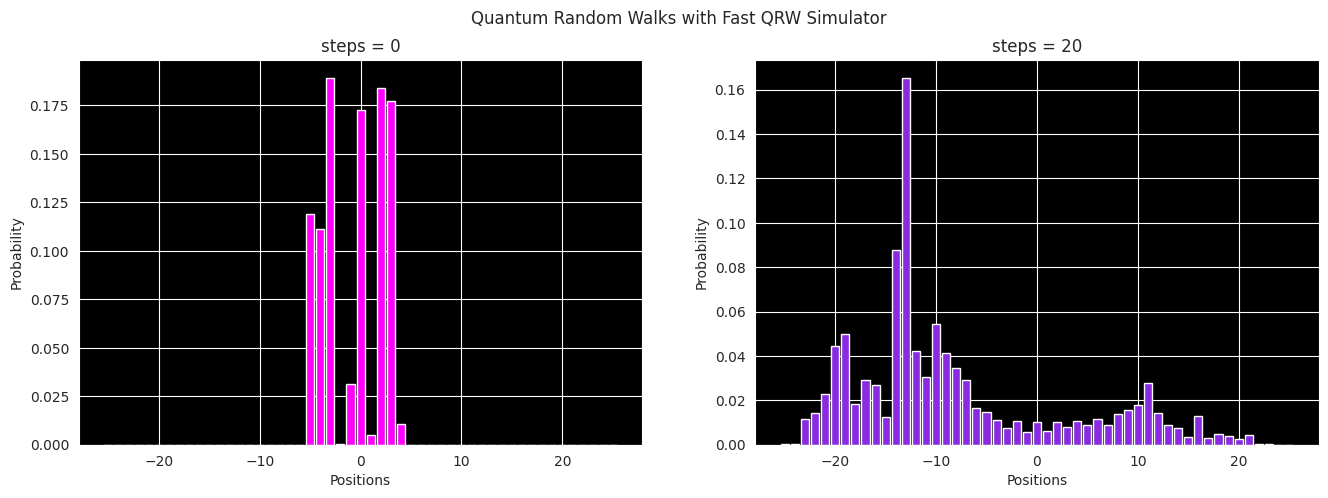

In [8]:
fast_sim = QRW_simulation(dim=1)  #specify the dimension of the QRW (in this case 1D)

U = np.array([[np.cos(theta/2),-np.exp(lamb*1j)*np.sin(theta/2)],
               [np.sin(theta/2),np.exp(lamb*1j)*np.cos(theta/2)]])

init_amp = np.zeros(51)
r = np.random.rand(10)  #create arbitrary real amplitudes
init_amp[20:30] = r/np.sqrt(np.sum(r**2))  #normalize initial amplitudes

length = int((len(init_amp)-1)/2) # distance between two ends and the center
max_steps = min(np.where(init_amp !=0)[0][0],len(init_amp)-1-np.where(init_amp != 0)[0][-1])  #maximum allowed steps (cannot exceed the boundaries of the input array)

fast_dist = fast_sim.simulate([coin_state],[U],init_amp,max_steps) #return probability distributions

fig,ax = plt.subplots(1,2,figsize=(16,5))
colors = ["magenta","blueviolet"]
dists = [init_amp**2,fast_dist]
titles = ["steps = 0",f"steps = {max_steps}"]

for i in range(2):
    ax[i].set_facecolor('black')
    ax[i].bar(range(-length,length+1),dists[i],color=colors[i])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Positions")
    ax[i].set_ylabel("Probability")
fig.suptitle("Quantum Random Walks with Fast QRW Simulator")
plt.show()

##### Return amplitude distributions

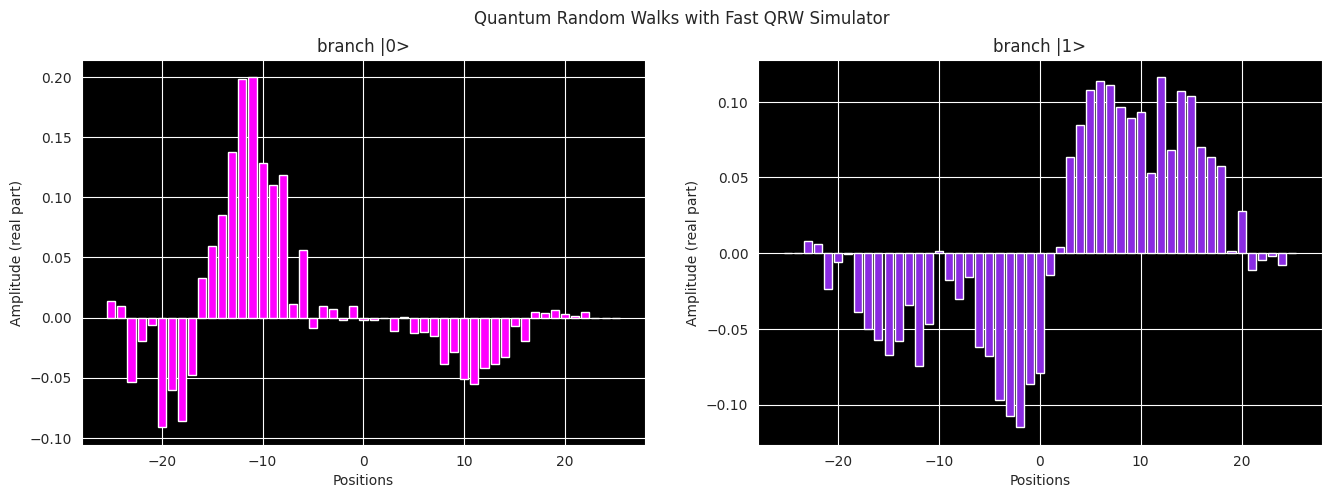

In [6]:
fast_amp = fast_sim.simulate([coin_state],[U],init_amp,max_steps,return_amp=True) #return amplitude distributions
branch0 = fast_amp[0].real #real amplitudes of branch |0>
branch1 = fast_amp[1].real #real amplitudes of branch |1>

fig,ax = plt.subplots(1,2,figsize=(16,5))
colors = ["magenta","blueviolet"]
amps = [branch0,branch1]
titles = ['branch |0>','branch |1>']

for i in range(2):
    ax[i].set_facecolor('black')
    ax[i].bar(range(-length,length+1),amps[i],color=colors[i])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Positions")
    ax[i].set_ylabel("Amplitude (real part)")
fig.suptitle("Quantum Random Walks with Fast QRW Simulator")
plt.show()

#### Apart from the unmatched versatility of the customized simulator, its computation speed is another compelling reason why it's more useful than circuit-based quantum simulators. The following runtime comparison perfectly highlights the advantage of the fast QRW simulator over the Qiskit Aer Simulator:



<img src="./QRW_simulation_time.png"  alt="Runtime comparison of different QRW simulators"  width="700px"  height="490px"  style="object-fit:cover"/>



### Visualizing the Fast QRW Simulation 



#### In _**qrw\_toolkit**_, we provide interactive visualization tools to help users better understand the dynamics of QRWs. For the basic 1D QRW, two types of plots can be generated: 'time\_slice' and 'timeline.' The 'time\_slice' plot shows one step or slice of the QRW evolution at a time, while the 'timeline' plot displays the entire evolution. The probability of each position is color\-coded, with the pink \(bright\) tone representing a higher value and the purple \(dark\) tone representing a lower value.



##### One single time slice



In [2]:
init_amp = np.array([1])
timeslice_1D = QRW_visualization(init_amp, max_steps=50 ,dim=1, plot_type="time_slice")
timeslice_1D.plot()

##### Entire timeline of QRW

<span style='font-size:medium'>The probability values at each step are normalized to the range \[0,1\] for better visualization, so they do not add up to 1. </span>


In [3]:
init_amp = np.array([0.3,0,0.5,0,0,0.2])
timeline_1D = QRW_visualization(init_amp, max_steps=70 ,dim=1, plot_type="timeline")
timeline_1D.plot()

## (3) Variations of QRWs



#### Aside from the basic 1D QRW discussed so far, there are other variations of QRW inspired by the core concept. In this section, we will demonstrate the 2\-dimensional QRW, harmonic QRW, QRW with qutrit, and QRW with memory.



## 3.1 Two-dimensional QRW



#### As discussed previously, QRW can be generalized to higher dimensions, with each coin dictating the trajectory of the walker in the associated dimension. For the 2D QRW, two coins are used to navigate the walker in the horizontal and vertical directions. Hence, there are 4 possible directions the walker can move along \-\-\- top right, top left, bottom right, and bottom left. The walker's position is descried by the Cartesian coordinate \(x,y\) and updated according to the states of the coins.



#### For 2D QRW, only "time_slice" plot is available and the color-coded probability values are again normalized to the range [0,1]

In [4]:
init_amp = np.zeros((11,11))
init_amp[5,5] = 1
timeslice_2D = QRW_visualization(init_amp, max_steps=50 ,dim=2)
timeslice_2D.plot()

## 3.2  Harmonic QRW



#### If we view each coin flip operation as an interactive event with the external system, then such events take place periodically for the QRW model considered so far. We can introduce an additional event with a different periodicity, which is an integer multiple of the period of the baseline event \(set to 1\), resulting in a harmonically\-driven QRW model. In theory, we can usher in as many long\-period harmonics as desired, expanding the scope of reachable distributions. However, more free parameters will follow as the complexity scales up. Consequently, only two harmonics are considered in our harmonic QRW model.

</br> 

#### Relative to the harmonic QRW, QRW models with only one event (and thus one baseline period) are denoted as "basic" QRW.



In [5]:
init_amp = np.array([1])
timeslice_1D_harmonic = QRW_visualization(init_amp, max_steps=50 ,dim=1, model="harmonic", plot_type="time_slice")  # specify the model argument as "harmonic"
timeslice_1D_harmonic.plot()

In [6]:
init_amp = np.array([0.3,0,0.5,0,0,0.2])
timeline_1D_harmonic = QRW_visualization(init_amp, max_steps=70 ,dim=1, model="harmonic", plot_type="timeline")
timeline_1D_harmonic.plot()

## 3.3 QRW with Qutrit



#### Due to the fact that QRW can be simulated purely classically, we can incorporate features that are otherwise difficult to realize on a quantum computer. For example, instead of using a typical qubit as the coin, multi\-level quantum system \(qudit\) can be applied as a multi\-sided coin, which allows for more directional instructions for the walker. Here we consider a 3\-sided coin represented by a qutrit. The three basis states of a qutrit $\ket{-1}$, $\ket{0}$, and $\ket{1}$ displace the walker by \-1, 0, and 1 unit, respectively. This protocol introduces a third branch of quantum state in the Schmidt decomposition, which entails more sophisticated interference behaviors among the different branches.



#### Pauli operators for a 3-level system (qutrit):

</br>

$\begin{equation} S_{x} = \hbar\sigma_{x} = \frac{\hbar}{\sqrt{2}} \begin{pmatrix} 0 & 1 & 0 \\ 1 & 0 & 1 \\ 0 & 1 & 0 \end{pmatrix} \end{equation}$

$\begin{equation} S_{y} = \hbar\sigma_{y} = \frac{\hbar}{\sqrt{2}} \begin{pmatrix} 0 & -i & 0 \\ i & 0 & -i \\ 0 & i & 0 \end{pmatrix} \end{equation}$

$\begin{equation} S_{z} = \hbar\sigma_{z} = \hbar \begin{pmatrix} 1 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & -1 \end{pmatrix} \end{equation}$

</br>

#### General rotation gates U($\theta$,$\phi$,$\lambda$) for a qutrit:

</br>

$\begin{equation} U(\theta,\phi,\lambda) = \begin{pmatrix} e^{i(\phi+\lambda)}\cos^{2}(\frac{\theta}{2}) & \frac{1}{\sqrt{2}}e^{i\phi}\sin(\theta) & e^{i(\phi-\lambda)}\sin^{2}(\frac{\theta}{2}) \\ -\frac{1}{\sqrt{2}}e^{i\lambda}\sin(\theta) & \cos(\theta) & \frac{1}{\sqrt{2}}e^{-i\lambda}\sin(\theta) \\ e^{-i(\phi-\lambda)}\sin^{2}(\frac{\theta}{2}) & -\frac{1}{\sqrt{2}}e^{-i\phi}\sin(\theta) & e^{-i(\phi+\lambda)}\cos^{2}(\frac{\theta}{2}) \end{pmatrix} \end{equation}$

</br>

#### It can be proven that $\phi$ merely contributes to the global phase of the position state of each branch. Hence, we can simply take $\phi = 0$, and the coin flip operator is again parametrized by $\theta$ and $\lambda$

</br>

#### For the 3-sided coin, we can define the coin state as 

</br>

$\begin{equation} \ket{C} = a \ket{1}+be^{i\phi_{1}} \ket{0} + \sqrt{1-a^{2}-b^{2}} e^{i\phi_{2}}\ket{-1} \end{equation}$

</br>

#### Therefore for a Qutrit QRW, there are 6 tunable parameters $\theta$, $\lambda$, $a$, $b$, $\phi_{1}$, $\phi_{2}$



In [7]:
init_amp = np.array([1])
timeslice_1D_qutrit = QRW_visualization(init_amp, max_steps=50 ,dim=1, model="qutrit", plot_type="time_slice")  #specify the model as "qutrit"
timeslice_1D_qutrit.plot()

In [8]:
init_amp = np.array([0.3,0,0.5,0,0,0.2])
timeline_1D_qutrit = QRW_visualization(init_amp, max_steps=70 ,dim=1, model="qutrit", plot_type="timeline")
timeline_1D_qutrit.plot()

## 3.4 QRW with memory



#### In a QRW with memory, each step the walker takes is governed by a different memory coin. Each memory coin is parameterized by the initial coin state, prepared using a Ry rotation, and by the entanglement with the preceding coins. This model accounts for the historical process and can generate a continuous spectrum of distributions, ranging from classical to quantum random walks, by varying the memory strength.

#### 1. Initially, each memory coin is initialized in a state $R_{y}(\phi_{i})\ket{0} = a_{i}\ket{0}+b_{i}\ket{1}$ that captures the intrinsic tendency of the walker in each step.

</br>

#### 2. The history of the walker is encoded and passed down to the new memory coin by the $CR_{y}(\theta)$ and $CR_{y}(-\theta)$ gate. Assume $R_{y}(\theta)\ket{0}=\alpha\ket{0}+\beta\ket{1}$ where $\theta$  quantifies the impact of the past on the present walker ( $\theta$ is also a measure of entanglement ). The first controlled gate nudges the new memory coin closer to $\ket{1}$ if the previous coin is in the $\ket{1}$ state, while the second controlled gate does the opposite.

</br>

#### 3. The walker's movement in each step is dictated by the accumulative effect of the historical record and the inclination of the current step.   

#### Just like in the basic QRW, the shift operator at each step is composed of multiple CNOT gates. These gates are conditioned on the memory coin of the given step.

#### In the circuit diagram below, the walker takes 4 steps (and thus 4 memory coins required) with he initial coin angles: $\frac{\pi}{3}$, $\frac{\pi}{4}$, $\frac{2\pi}{3}$, $\pi$, along with a fixed memory angle $\frac{\pi}{5}$. The first memory coin has no previous memory, so the shift operator is directly applied to the position state. From the second step onward, the memory is inherited before the shift occurs.

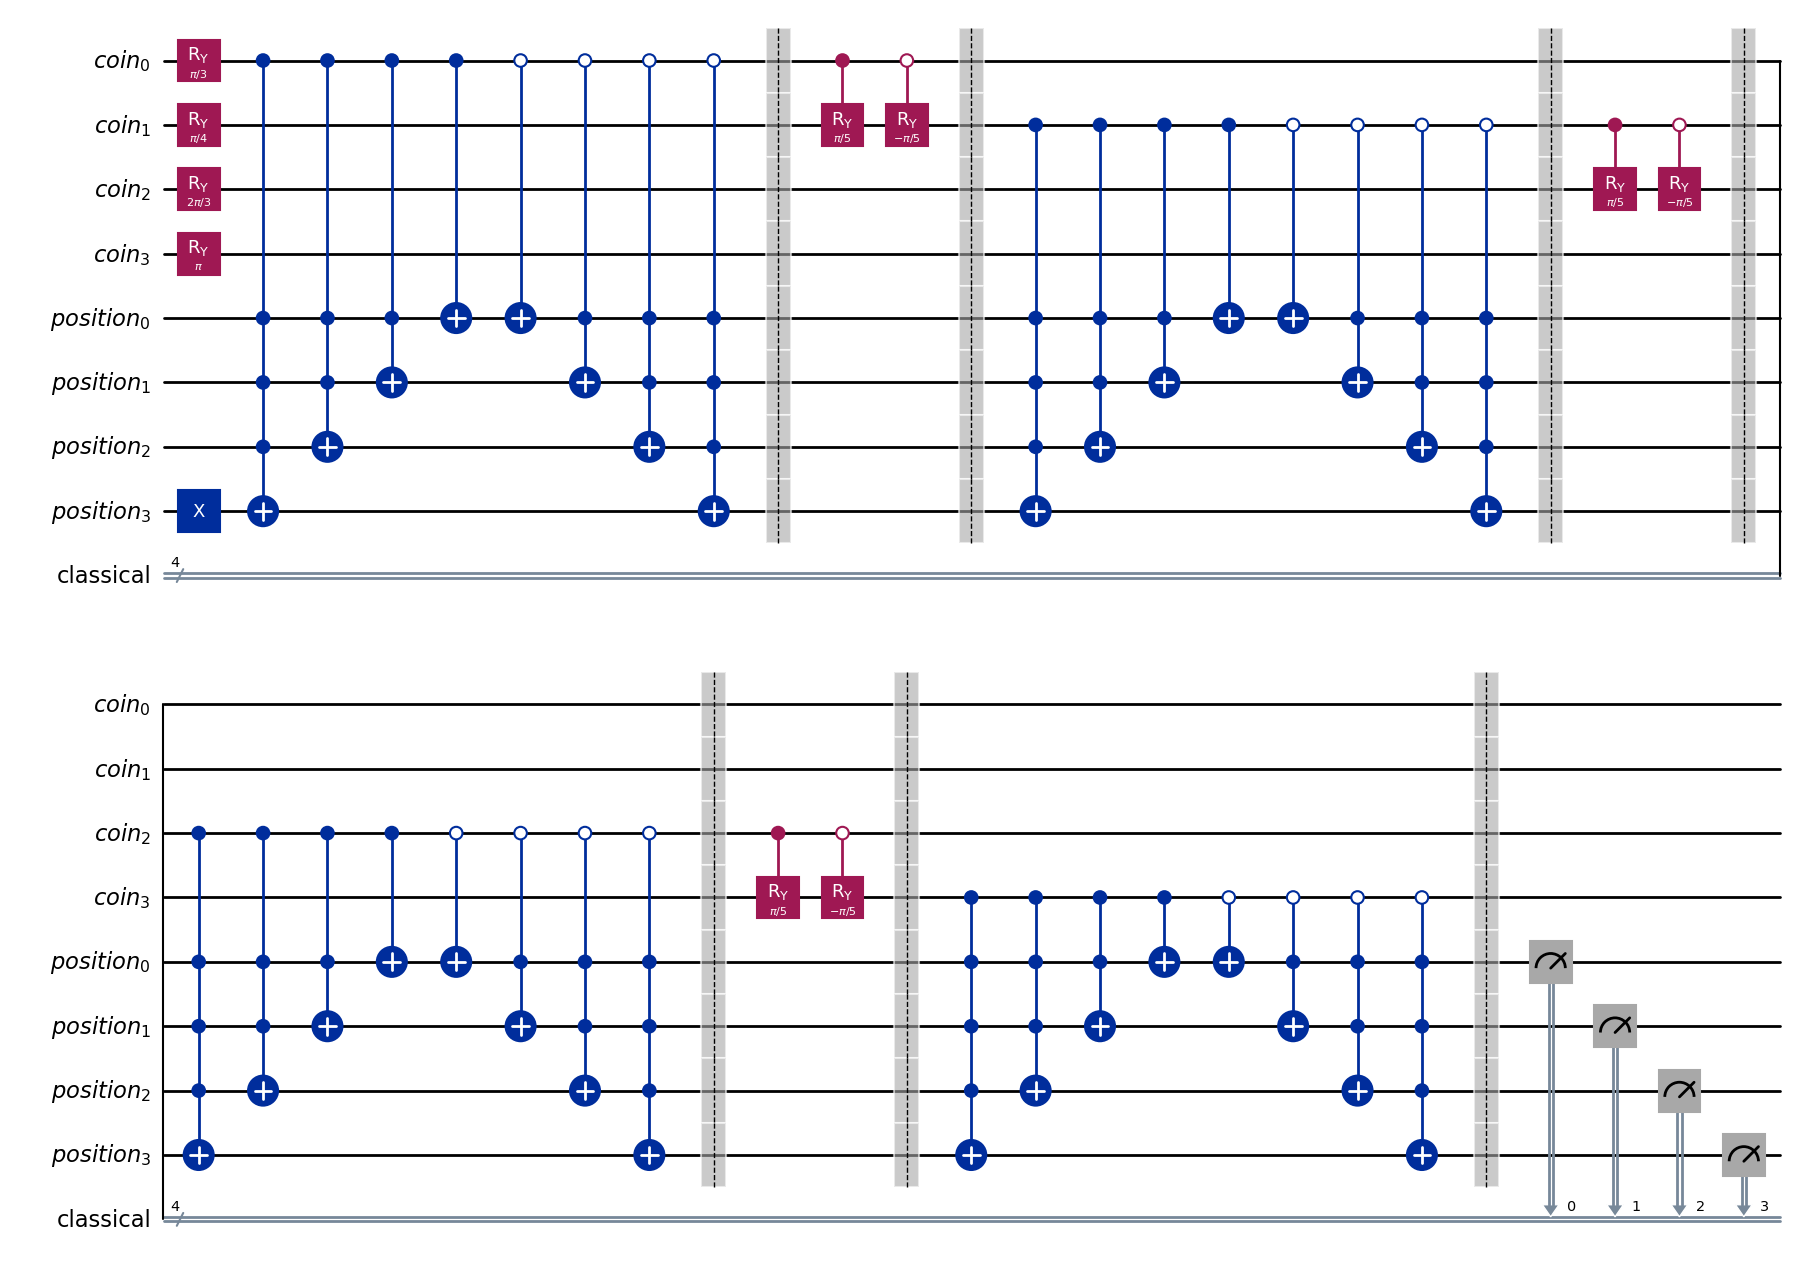

In [11]:
qiskit_sim = QRW_qiskit_simulation()
coin_angles = np.array([np.pi/3,np.pi/4,np.pi*2/3,np.pi])  #coin angle ϕ
memory_angle = np.pi/5 #memory angle θ
circ = qiskit_sim.memory_circuit(coin_angles,memory_angle)

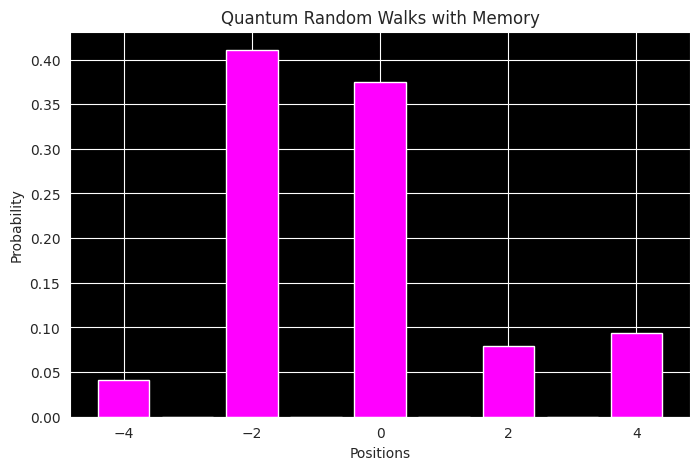

In [12]:
qiskit_memory_dist = qiskit_sim.memory_simulate(coin_angles,memory_angle)
plt.figure(figsize=(8,5))
plt.gca().set_facecolor('black')
plt.bar(range(-len(coin_angles),len(coin_angles)+1),qiskit_memory_dist,color="magenta")
plt.title("Quantum Random Walks with Memory")
plt.xlabel("Positions")
plt.ylabel("Probability")
plt.show()

#### We can see the transition from classical to quantum random walks \(purple to pink\) when tuning the θ value \(memory angle\) closer to $\frac{\pi}{2}$, which corresponds to the maximal level of memory and entanglement.



In [13]:
colors = ['blueviolet', 'magenta']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

def update(phi1,phi2,phi3,phi4,theta):
    
    coin_angles = np.array([phi1,phi2,phi3,phi4])

    plt.clf()
    fig, ax = plt.subplots(2,2,figsize=(12,9))

    for i in range(4):
        ax[i//2][i%2].set_facecolor('black')
        result = qiskit_sim.memory_simulate(coin_angles[:i+1],theta,shots=1000)
        norm = 1 - (abs(theta-np.pi/2) / (np.pi / 2))
        ax[i//2][i%2].bar(range(-i-1,i+2),result,color=cmap(norm))
        ax[i//2][i%2].set_xlabel("Positions")
        ax[i//2][i%2].set_ylabel("Probability")
        ax[i//2][i%2].set_title(f"Steps = {i+1}")
        if i==0:
            ax[0][0].set_xticks([-1,0,1],labels=['-1','0','1'])
    
    fig.suptitle(f"Quantum Random Walks with Memory \n ϕ1={phi1:.3f}  ϕ2={phi2:.3f}  ϕ3={phi3:.3f}  ϕ4={phi4:.3f}  θ={theta:.3f}")
    plt.tight_layout()
    plt.show()
    
interact(update, phi1 = widgets.FloatSlider(value=np.pi/2,min=0,max=np.pi,step=0.05*np.pi,description='ϕ1'),
         phi2 = widgets.FloatSlider(value=np.pi/2,min=0,max=np.pi,step=0.05*np.pi,description='ϕ2'),
         phi3 = widgets.FloatSlider(value=np.pi/2,min=0,max=np.pi,step=0.05*np.pi,description='ϕ3'),
         phi4 = widgets.FloatSlider(value=np.pi/2,min=0,max=np.pi,step=0.05*np.pi,description='ϕ4'),
         theta = widgets.FloatSlider(value=0,min=0,max=np.pi,step=0.05*np.pi,description='θ'))

interactive(children=(FloatSlider(value=1.5707963267948966, description='ϕ1', max=3.141592653589793, step=0.15…

<function __main__.update(phi1, phi2, phi3, phi4, theta)>

##### We now go back to the simple, 1 dimensional coined QRW and try to get ready to use it to model real world data. With the powerful fast QRW simulator we described in the last section, we can use a QRW to fit probability distributions and interpret their underlying dynamics by discovering the corresponding QRW process. In the _**qrw\_toolkit**_, we provide optimization tools \(QRW\_optimization class\) for fitting random target distributions. Several examples will be demonstrated below. Moreover, we have developed an interactive application—_**DisQover**_—which enhances the user experience with its intuitive interface, facilitating the discovery of hidden trails with the mysterious quantum walker!


## (4) Fitting QRWs


#### Basic QRW \(one coin flip operation\)



As a first example, we try to fit a small example probability distribution.

MSE: 1.9952834754847844e-05, std : 0.07061325516170888, x0: 0, steps: 4, θ: 0.887, λ: 3.724, a: 0.773, ϕ: 4.112


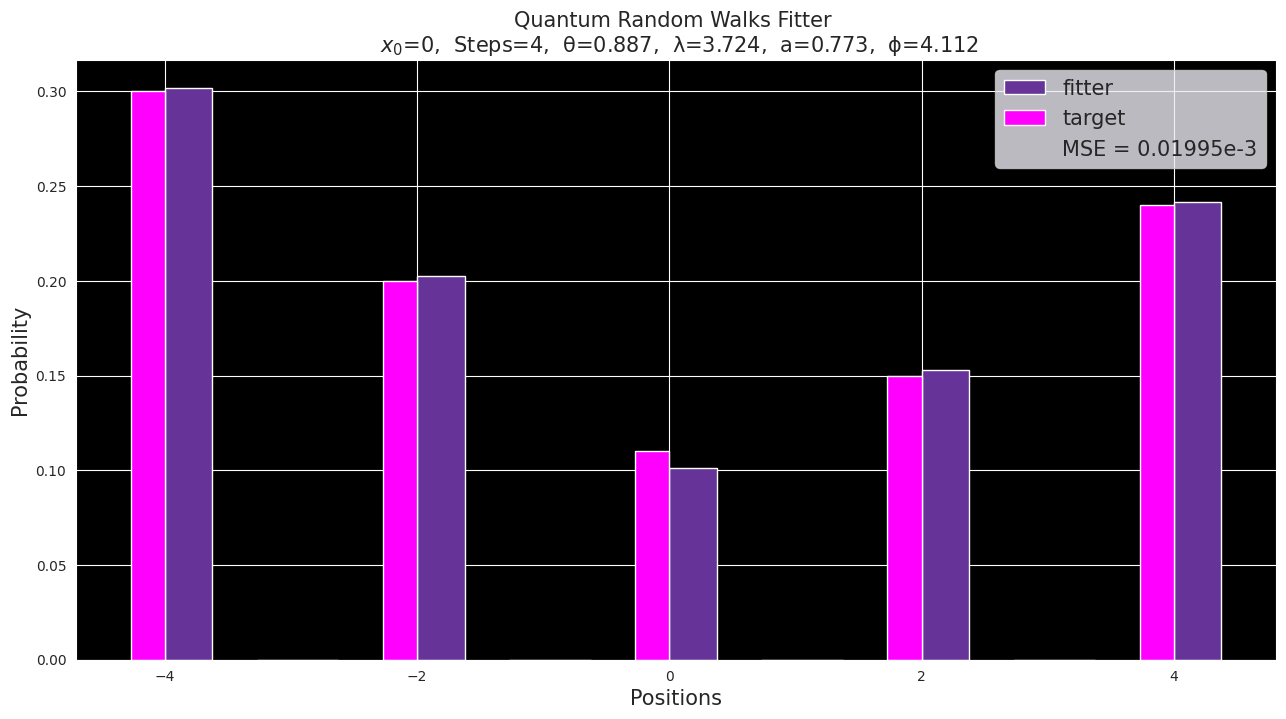

In [12]:
end_prob= np.array([0.3,0.2,0.11,0.15,0.24])

basic_opt = QRW_optimization(end_prob)
basic_best_params, basic_loss, basic_fit_prob = basic_opt.optimize(rounds=500)

We see that a good fit can be generated with a QRW model. We will now try to fit more randomly-generated distributions.

MSE: 0.0030824129682831413, std : 0.08637059278535489, x0: 0, steps: 4, θ: 1.225, λ: 1.728, a: 0.840, ϕ: 2.460
MSE: 0.0033052042040290336, std : 0.028924180435376267, x0: 1, steps: 8, θ: 1.518, λ: 0.516, a: 0.608, ϕ: 1.427
MSE: 0.0038650750803812823, std : 0.015164285833696185, x0: 2, steps: 12, θ: 1.638, λ: 4.468, a: 0.794, ϕ: 3.379
MSE: 0.0024378602160874474, std : 0.0113798922514101, x0: -4, steps: 15, θ: 1.447, λ: 2.190, a: 0.670, ϕ: 2.402


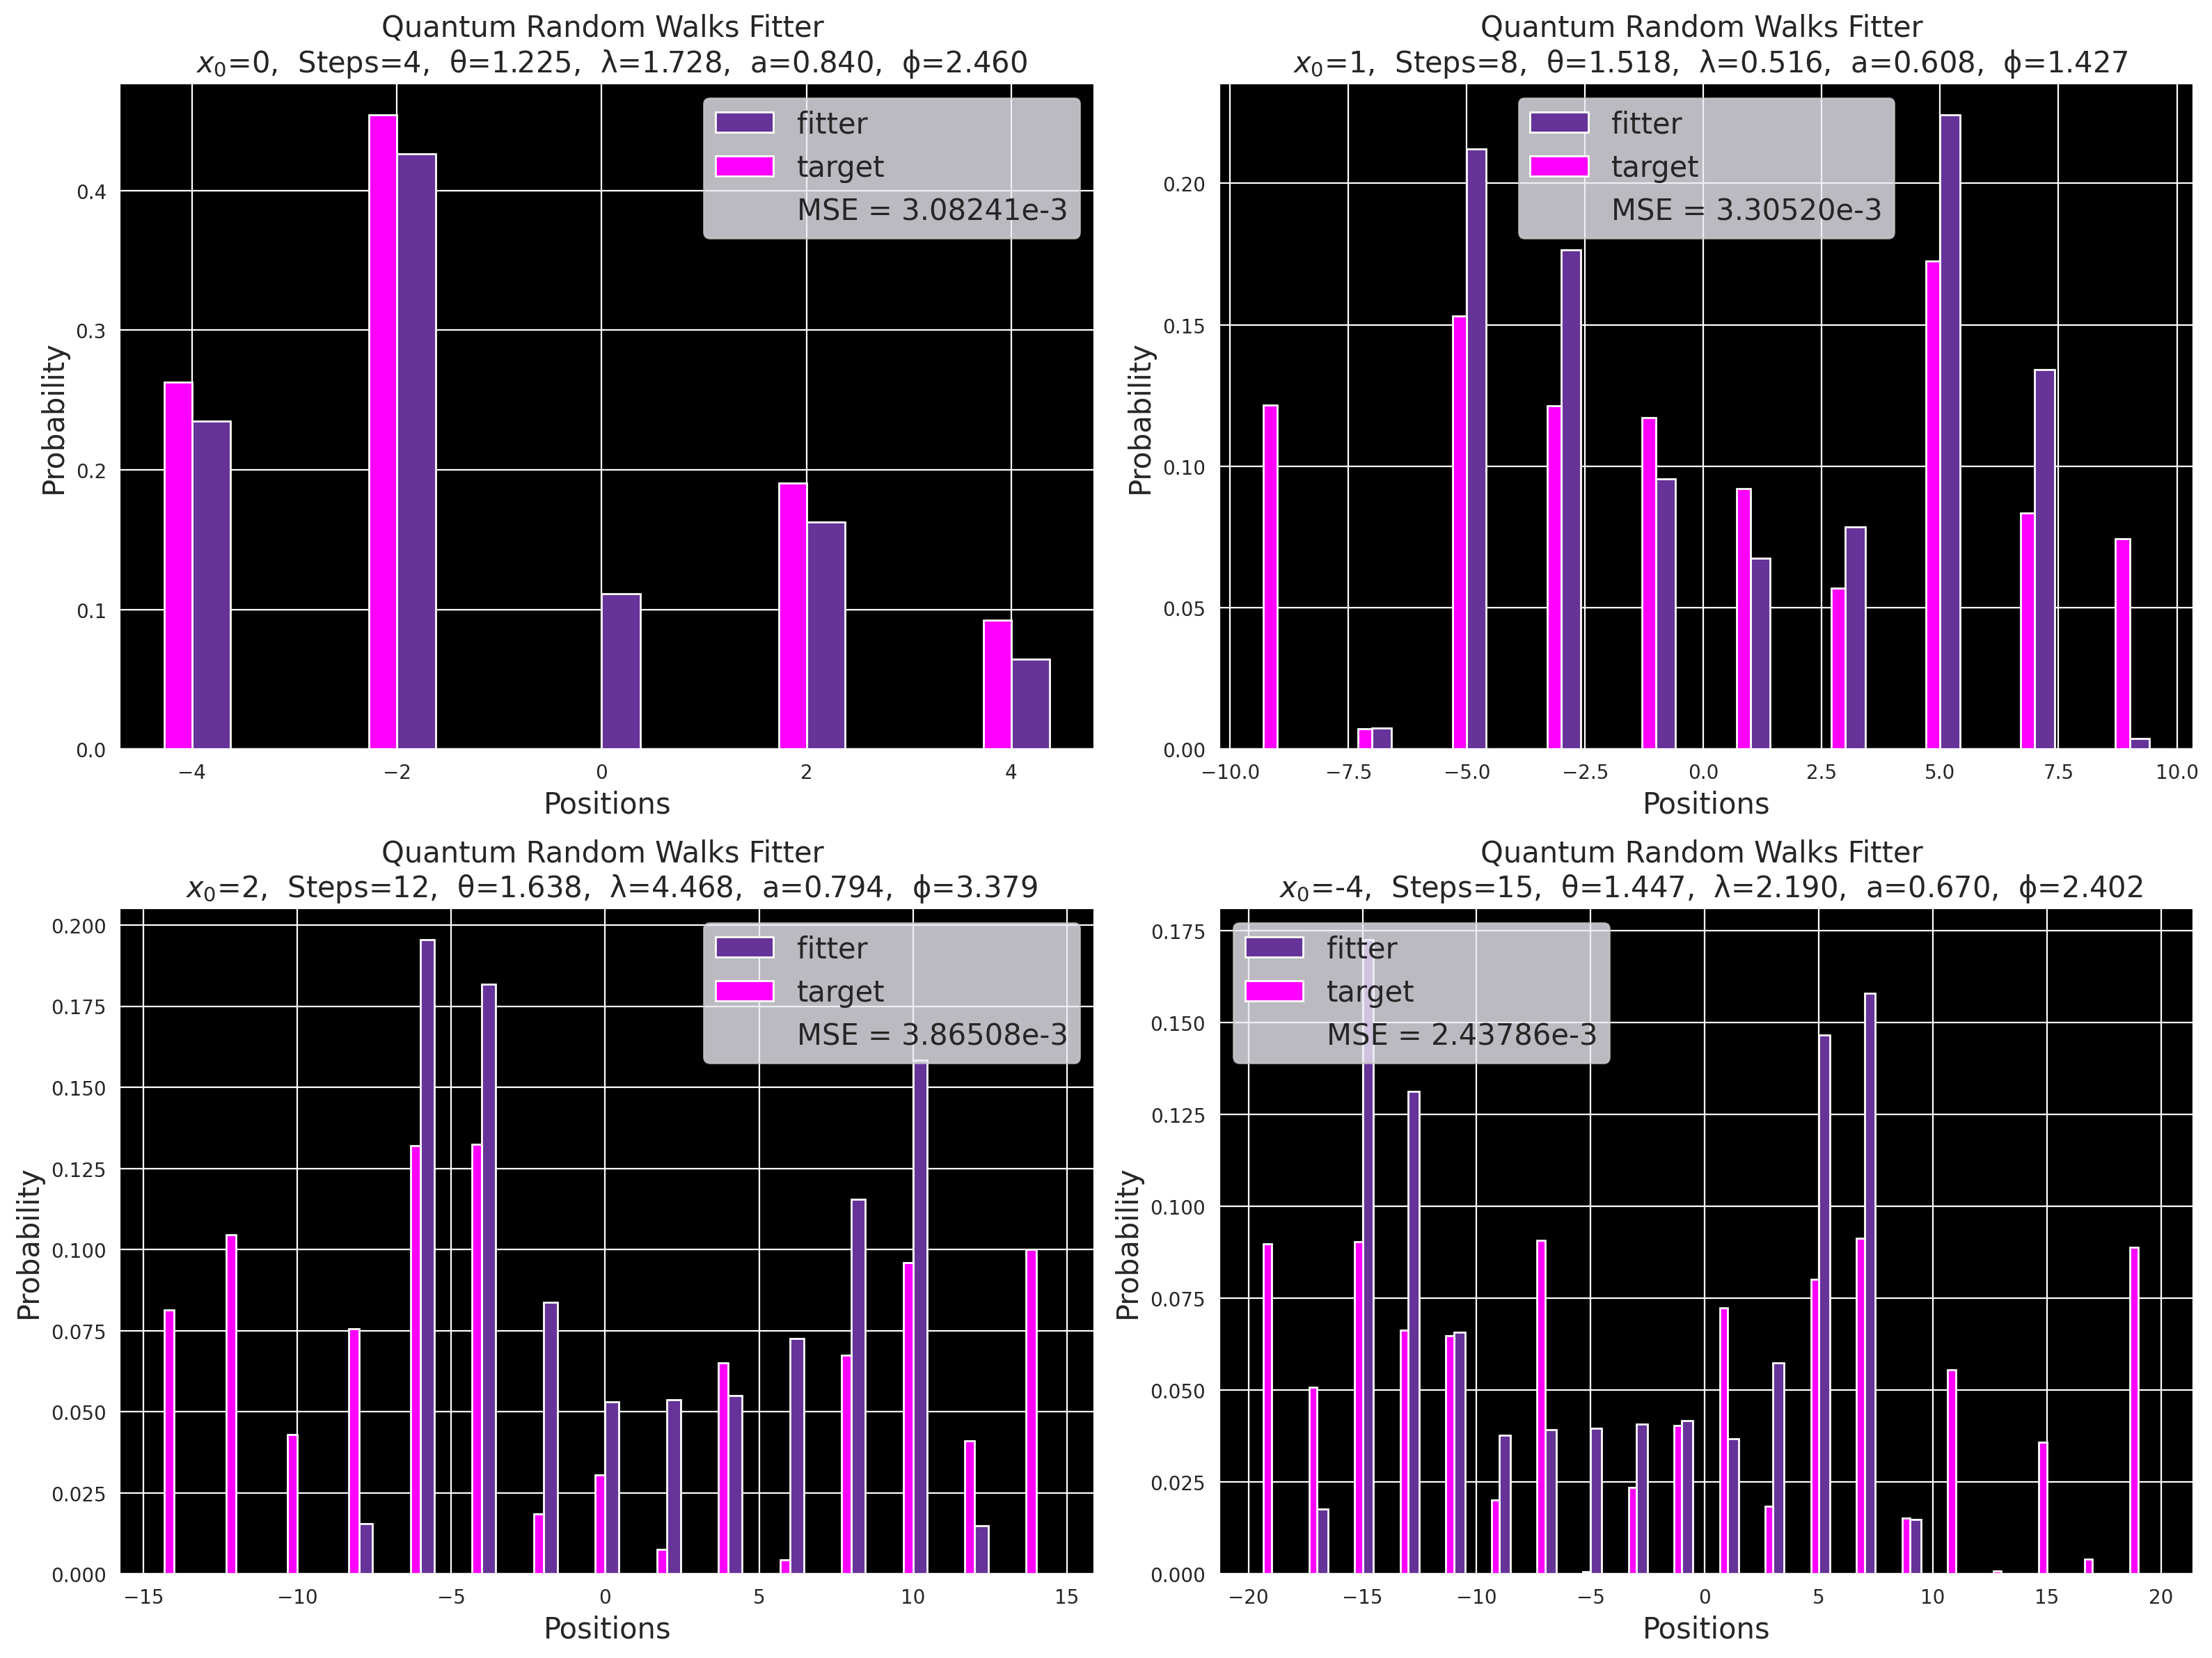

In [30]:
end_probs = []
basic_best_params = []
basic_loss = []
basic_fit_prob = []
for i in range(1,5):
    np.random.seed(i)
    end_prob = np.random.rand(5*i)  # generate random distributions
    end_prob = end_prob/np.sum(end_prob)
    end_probs.append(end_prob)
    basic_opt = QRW_optimization(end_prob)
    params, loss, prob = basic_opt.optimize(rounds=500,plot=False)  #deactivate plotting
    basic_best_params.append(params)
    basic_loss.append(loss)
    basic_fit_prob.append(prob)
    
fig,ax = plt.subplots(2,2,figsize=(16,12))

for i in range(4):
    ax[i//2][i%2].set_facecolor('black')
    n = len(basic_fit_prob[i])
    if n %2 == 1:
        N = int((n-1)/2)
        ax[i//2][i%2].bar(range(-N,N+1),basic_fit_prob[i],label="fitter",width=0.7*(0.5+0.01*N),align="edge",color="rebeccapurple")
        ax[i//2][i%2].bar(range(-N,N+1),QRW_simulation(1).insert_zero(end_probs[i]),label="target",width=-0.5*(0.5+0.01*N),align="edge",color="magenta")
    else:
        N = int(n/2)
        ax[i//2][i%2].bar(range(-N,N),basic_fit_prob[i],label="fitter",width=0.7*(0.5+0.01*N),align="edge",color="rebeccapurple")
        ax[i//2][i%2].bar(range(-N,N),QRW_simulation(1).insert_zero(end_probs[i]),label="target",width=-0.5*(0.5+0.01*N),align="edge",color="magenta")
    
    ax[i//2][i%2].bar([0],[0],label=f"MSE = {1000*basic_loss[i]:.5f}e-3",color="white",alpha=0.01)
    ax[i//2][i%2].set_xlabel("Positions",fontsize=15)
    ax[i//2][i%2].set_ylabel("Probability",fontsize=15)
    
    params = [item for key,item in basic_best_params[i].items()]
        
    ax[i//2][i%2].set_title(f"Quantum Random Walks Fitter \n $x_{0}$={params[0]},  Steps={params[1]},  θ={params[2]:.3f},  λ={params[3]:.3f},  a={params[4]:.3f},  ϕ={params[5]:.3f}",fontsize=15)
    ax[i//2][i%2].legend(fontsize=15)
    
plt.tight_layout()

#### Harmonic QRW \(two coin flip operations\)



Even though we do not suggest to use the harmonic QRW processes (or memory QRW) for actual data fitting (for real world applications, stability and the high number of parameters (similar fits with different parameters may be possible) presumably makes these processes too complicated und unstable), here are some examples we have experimented with:

MSE: 2.090583791885148e-11, std : 0.07294469483820212, x0: 0, steps: 4, θ1: 1.005, λ1: 5.346, θ2: 1.470, λ2: 3.534, a: 0.391, ϕ: 4.731, period: 3


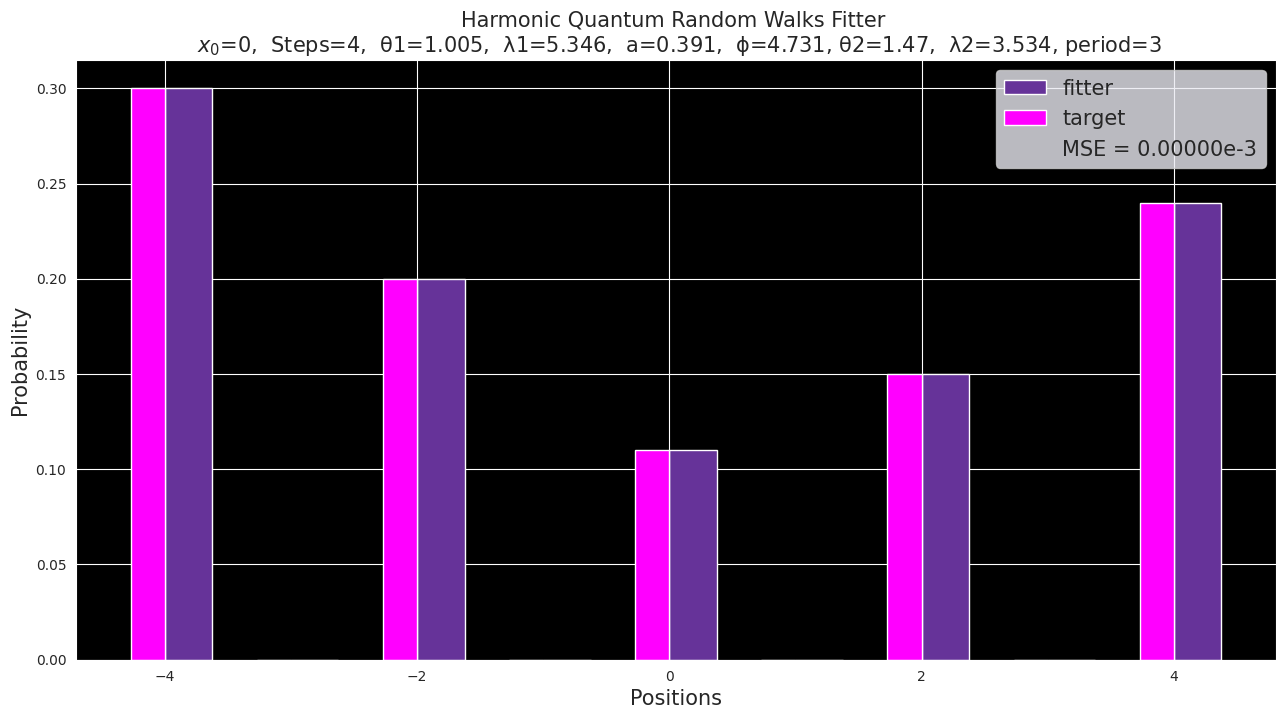

In [13]:
#same target distribution as in basic QRW
harmonic_opt = QRW_optimization(end_prob,model="harmonic")
harmonic_best_params, harmonic_loss, harmonic_fit_prob = harmonic_opt.optimize(rounds=500)

MSE: 0.003081653158093222, std : 0.08741596908347772, x0: 0, steps: 4, θ1: 1.216, λ1: 3.757, θ2: 1.216, λ2: 1.819, a: 0.843, ϕ: 4.614, period: 2
MSE: 0.0018583429301400618, std : 0.02837549329903314, x0: 0, steps: 9, θ1: 0.864, λ1: 0.588, θ2: 0.000, λ2: 3.440, a: 0.642, ϕ: 1.391, period: 4
MSE: 0.0016387151176728973, std : 0.017342833145761936, x0: 0, steps: 14, θ1: 0.813, λ1: 5.190, θ2: 1.605, λ2: 1.542, a: 0.728, ϕ: 5.142, period: 4
MSE: 0.0016939913251840955, std : 0.011690756738230928, x0: -4, steps: 15, θ1: 1.017, λ1: 2.988, θ2: 1.547, λ2: 3.078, a: 0.641, ϕ: 5.391, period: 4


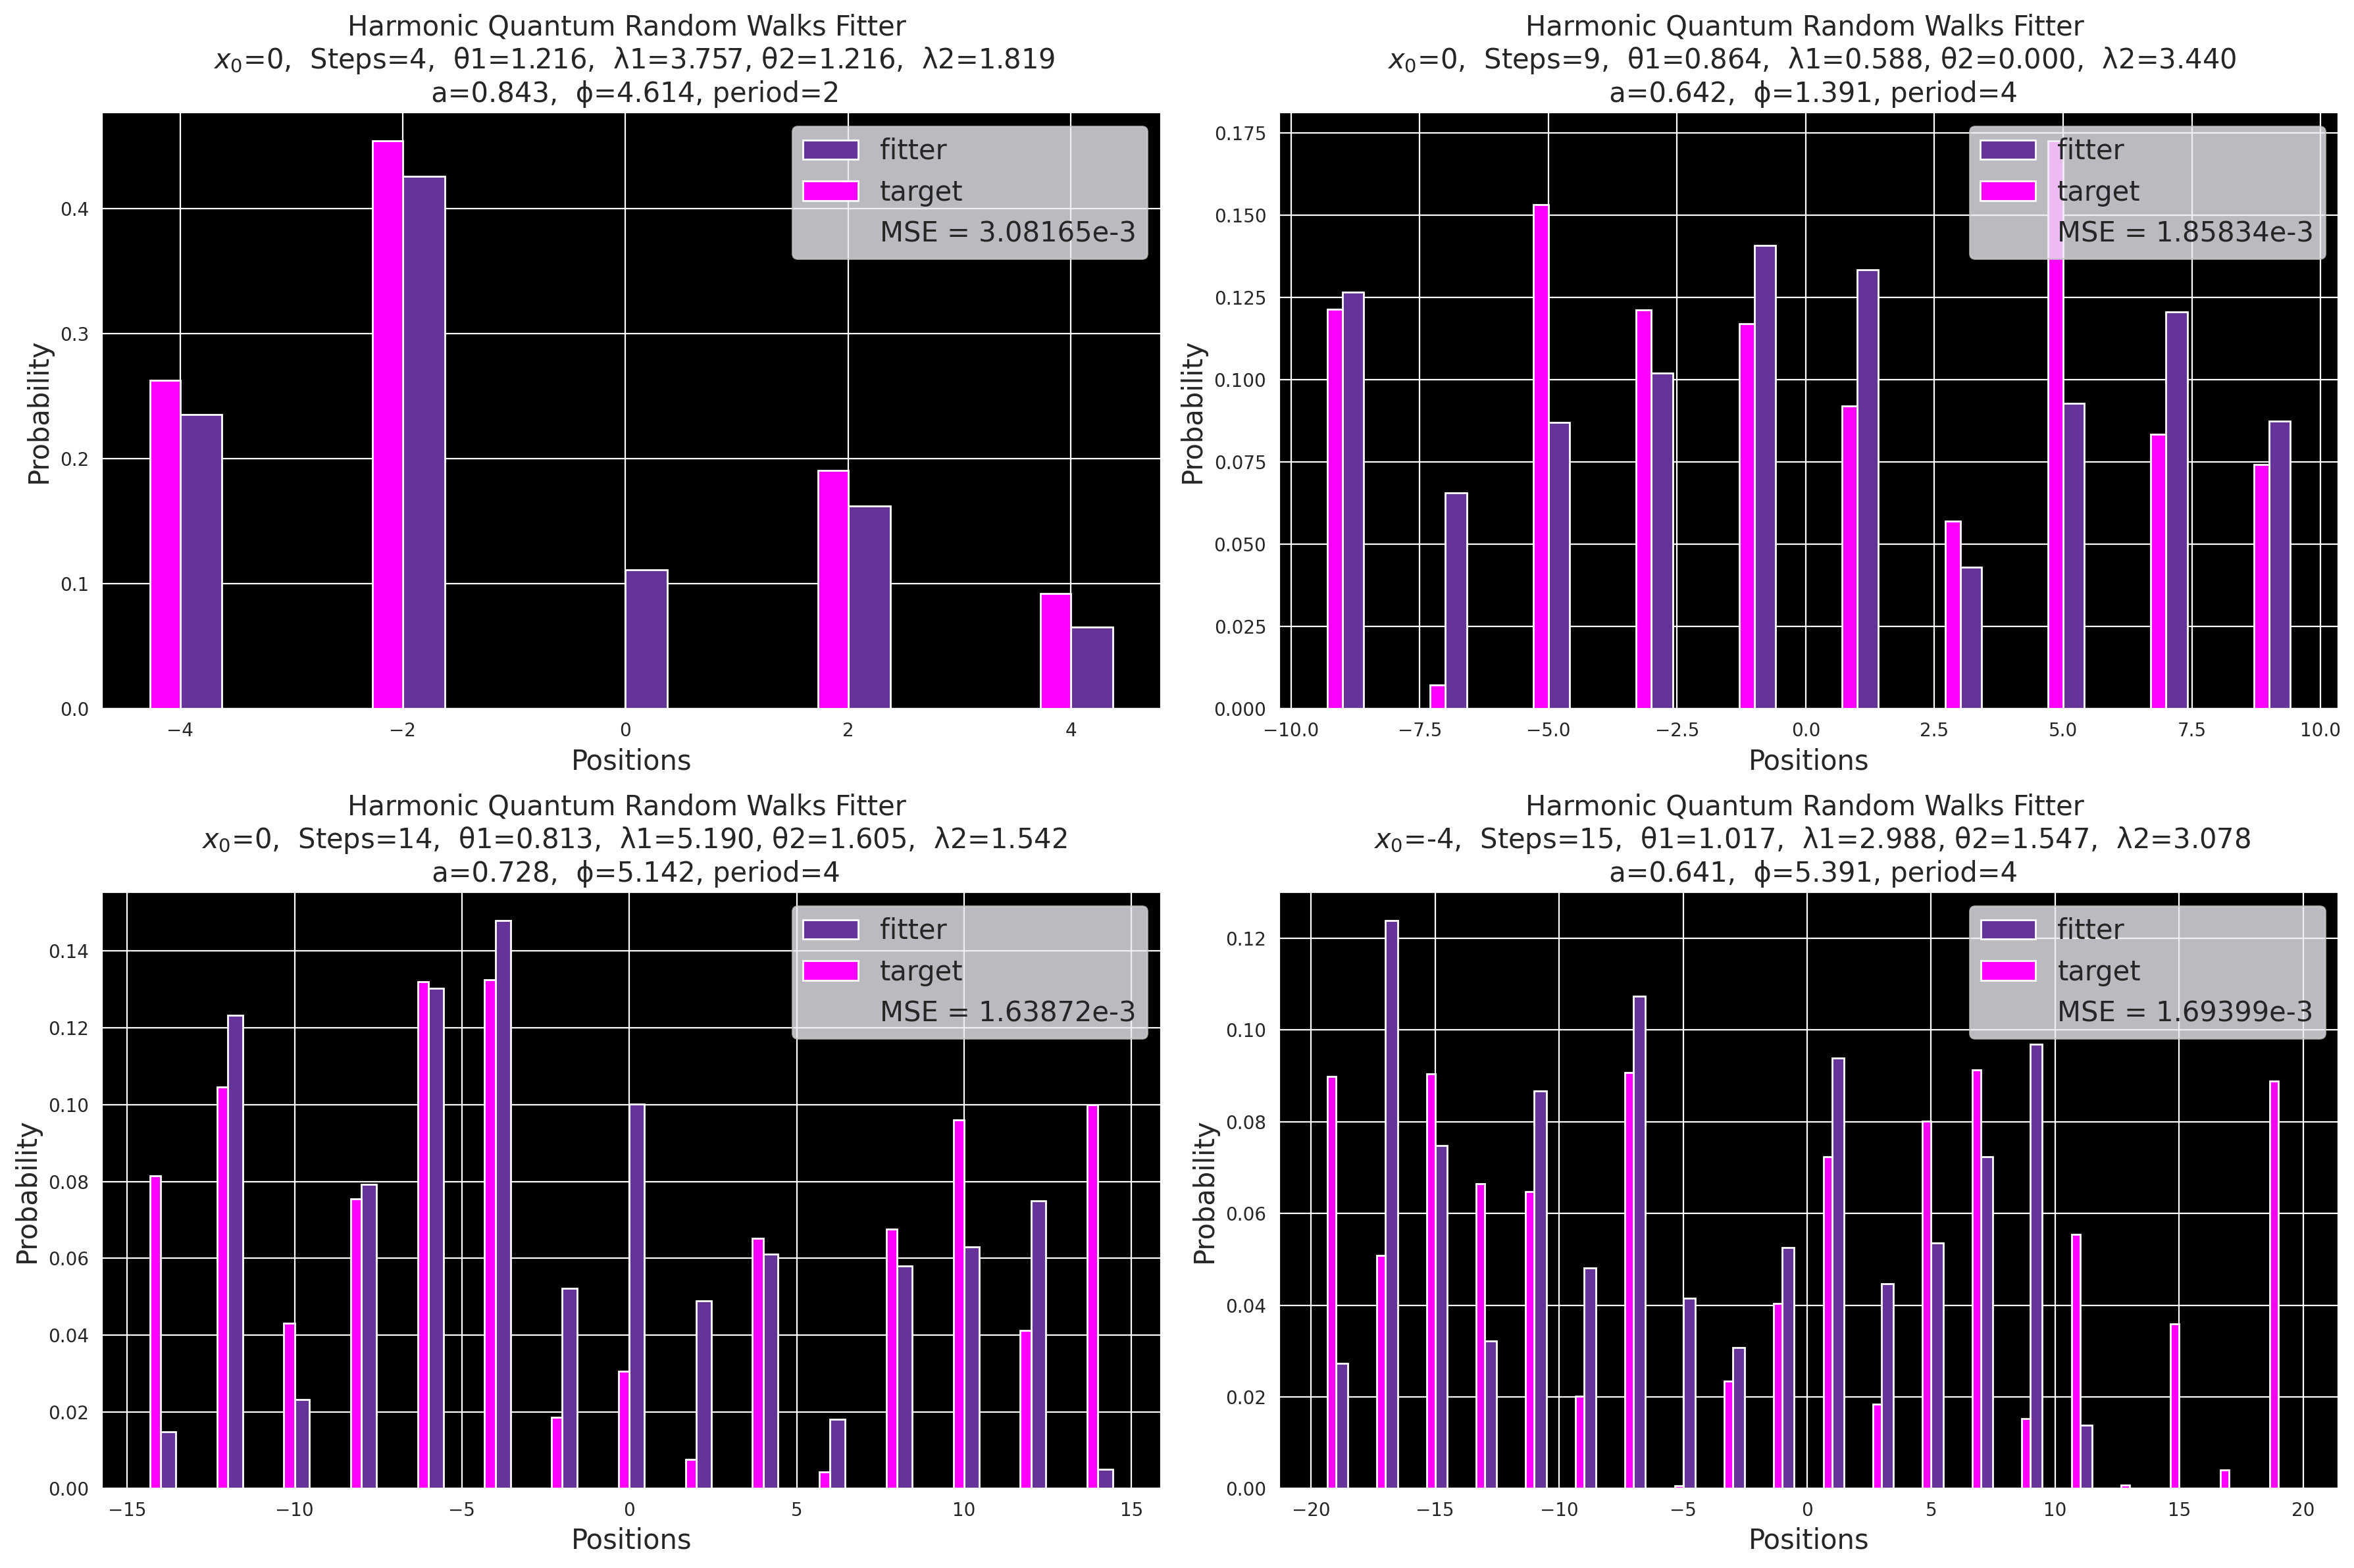

In [34]:
#same target distribution as in basic QRW
harmonic_best_params = []
harmonic_loss = []
harmonic_fit_prob = []
for i in range(4):
    end_prob = end_probs[i]
    harmonic_opt = QRW_optimization(end_prob,model="harmonic")
    params, loss, prob = harmonic_opt.optimize(rounds=500,plot=False)
    harmonic_best_params.append(params)
    harmonic_loss.append(loss)
    harmonic_fit_prob.append(prob)
    
fig,ax = plt.subplots(2,2,figsize=(18,12))

for i in range(4):
    ax[i//2][i%2].set_facecolor('black')
    n = len(harmonic_fit_prob[i])
    if n %2 == 1:
        N = int((n-1)/2)
        ax[i//2][i%2].bar(range(-N,N+1),harmonic_fit_prob[i],label="fitter",width=0.7*(0.5+0.01*N),align="edge",color="rebeccapurple")
        ax[i//2][i%2].bar(range(-N,N+1),QRW_simulation(1).insert_zero(end_probs[i]),label="target",width=-0.5*(0.5+0.01*N),align="edge",color="magenta")
    else:
        N = int(n/2)
        ax[i//2][i%2].bar(range(-N,N),harmonic_fit_prob[i],label="fitter",width=0.7*(0.5+0.01*N),align="edge",color="rebeccapurple")
        ax[i//2][i%2].bar(range(-N,N),QRW_simulation(1).insert_zero(end_probs[i]),label="target",width=-0.5*(0.5+0.01*N),align="edge",color="magenta")
    
    ax[i//2][i%2].bar([0],[0],label=f"MSE = {1000*harmonic_loss[i]:.5f}e-3",color="white",alpha=0.01)
    ax[i//2][i%2].set_xlabel("Positions",fontsize=15)
    ax[i//2][i%2].set_ylabel("Probability",fontsize=15)
    
    params = [item for key,item in harmonic_best_params[i].items()]
        
    ax[i//2][i%2].set_title(f"Harmonic Quantum Random Walks Fitter \n $x_{0}$={params[0]},  Steps={params[1]},  θ1={params[2]:.3f},  λ1={params[3]:.3f}, θ2={params[4]:.3f},  λ2={params[5]:.3f} \n a={params[6]:.3f},  ϕ={params[7]:.3f}, period={params[8]}",fontsize=15)
    ax[i//2][i%2].legend(fontsize=15)
    
plt.tight_layout()

For smaller distributions, the higher complexity of harmonic QRW might yield a better fit than the basic model within a reasonable runtime.